<a href="https://colab.research.google.com/github/edwardleetenafly/LA-net/blob/main/lanet_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import numpy as np
from pathlib import Path

root = Path("/content/drive/MyDrive/la_net/preprocessed")

files = list(root.glob("*_image.npy"))
print("Number of preprocessed images:", len(files))
print(files[:5])


Number of preprocessed images: 20
[PosixPath('/content/drive/MyDrive/la_net/preprocessed/la_003_image.npy'), PosixPath('/content/drive/MyDrive/la_net/preprocessed/la_004_image.npy'), PosixPath('/content/drive/MyDrive/la_net/preprocessed/la_005_image.npy'), PosixPath('/content/drive/MyDrive/la_net/preprocessed/la_007_image.npy'), PosixPath('/content/drive/MyDrive/la_net/preprocessed/la_009_image.npy')]


In [3]:
sample = np.load(root / "la_003_image.npy")
print("Shape:", sample.shape)
print("Min:", sample.min(), "Max:", sample.max())


Shape: (128, 128, 128)
Min: -1.6925095 Max: 3.4350688


In [5]:
import torch
from torch.utils.data import Dataset
import numpy as np
from pathlib import Path
import pandas as pd

root = Path("/content/drive/MyDrive/la_net")
prep = root / "preprocessed"

# Load splits
splits = pd.read_csv(root / "splits.csv")

class LADataset(Dataset):
    def __init__(self, df, prep_dir):
        self.df = df
        self.prep_dir = prep_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        cid = row["case_id"]

        # Load arrays
        img = np.load(self.prep_dir / f"{cid}_image.npy")  # float32
        msk = np.load(self.prep_dir / f"{cid}_mask.npy")    # uint8

        # Ensure masks are strictly binary floats (VERY IMPORTANT)
        msk = (msk > 0).astype(np.float32)

        # Add channel dimension: (1,128,128,128)
        img = img[np.newaxis, ...]
        msk = msk[np.newaxis, ...]

        return torch.tensor(img, dtype=torch.float32), torch.tensor(msk, dtype=torch.float32)



In [6]:
train_df = splits[splits.split == "train"]
val_df   = splits[splits.split == "val"]

train_dataset = LADataset(train_df, prep)
val_dataset   = LADataset(val_df, prep)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))


Train size: 14
Val size: 3


In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Test one batch
img, msk = next(iter(train_loader))
print("Batch img shape:", img.shape)
print("Batch msk shape:", msk.shape)


Batch img shape: torch.Size([1, 1, 128, 128, 128])
Batch msk shape: torch.Size([1, 1, 128, 128, 128])


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# ---------------------------------------------------------
# Utility: crop / pad tensor A to match tensor B's spatial size
# ---------------------------------------------------------
def match_shape(src, target):
    """
    Ensures that src has the same spatial size as target.
    Crops symmetrically if src is larger, pads if smaller.
    """
    diff = [src.size(i) - target.size(i) for i in range(2, 5)]
    out = src

    # crop if needed
    crop_slices = []
    for d in diff:
        if d == 0:
            crop_slices.append(slice(None))
        elif d > 0:
            # crop center region
            start = d // 2
            end = start + target.size(2 + len(crop_slices))
            crop_slices.append(slice(start, end))
        else:
            crop_slices.append(slice(None))

    # apply cropping on spatial dims
    out = out[:, :, crop_slices[0], crop_slices[1], crop_slices[2]]

    # pad if needed
    pd = []
    for i, d in enumerate(diff):
        if d < 0:
            # missing -d voxels → pad evenly
            pad = (-d) // 2
            extra = (-d) % 2
            # order in PyTorch: (W_left, W_right, H_left, H_right, D_left, D_right)
            if i == 0:  # depth
                pd.extend([pad, pad + extra])
            elif i == 1:  # height
                pd.extend([pad, pad + extra])
            else:  # width
                pd.extend([pad, pad + extra])
        else:
            pd.extend([0, 0])

    if sum(pd) > 0:
        out = F.pad(out, tuple(pd[::-1]))  # reverse for correct order

    return out


# ---------------------------------------------------------
# Double Conv Block (Conv3D → IN3D → ReLU → Conv3D → IN3D → ReLU)
# ---------------------------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_c),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


# ---------------------------------------------------------
# FINAL Updated 3D U-Net
# ---------------------------------------------------------
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=16):
        super().__init__()

        # -----------------
        # Encoder
        # -----------------
        self.enc1 = DoubleConv(in_channels, base_channels)
        self.enc2 = DoubleConv(base_channels, base_channels * 2)
        self.enc3 = DoubleConv(base_channels * 2, base_channels * 4)

        # -----------------
        # Bottleneck
        # -----------------
        self.bottleneck = DoubleConv(base_channels * 4, base_channels * 8)

        # -----------------
        # Decoder
        # -----------------
        self.up3 = nn.ConvTranspose3d(base_channels * 8, base_channels * 4, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(base_channels * 8, base_channels * 4)

        self.up2 = nn.ConvTranspose3d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(base_channels * 4, base_channels * 2)

        self.up1 = nn.ConvTranspose3d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(base_channels * 2, base_channels)

        # -----------------
        # Final output head
        # raw logits → used with BCEWithLogitsLoss
        # -----------------
        self.out_conv = nn.Conv3d(base_channels, out_channels, kernel_size=1)

        # MaxPool once
        self.pool = nn.MaxPool3d(2)

    def forward(self, x):
        # ---- Encoder ----
        e1 = self.enc1(x)
        p1 = self.pool(e1)

        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        e3 = self.enc3(p2)
        p3 = self.pool(e3)

        # ---- Bottleneck ----
        b = self.bottleneck(p3)

        # ---- Decoder ----
        u3 = self.up3(b)
        u3 = match_shape(u3, e3)  # safeguard
        d3 = self.dec3(torch.cat([u3, e3], dim=1))

        u2 = self.up2(d3)
        u2 = match_shape(u2, e2)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        u1 = match_shape(u1, e1)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        # Output logits
        return self.out_conv(d1)



In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = UNet3D().to(device)
print("Total parameters:", sum(p.numel() for p in model.parameters()))


Device: cuda
Total parameters: 1400561


In [11]:
import torch
import torch.nn as nn

# -----------------------
# Dice coefficient (metric)
# -----------------------
def dice_score(pred, target, eps=1e-6):
    # pred, target shape: (B, 1, D, H, W)
    pred = torch.sigmoid(pred)  # convert logits → probability
    pred = (pred > 0.5).float()  # threshold for metric

    intersection = (pred * target).sum(dim=(1,2,3,4))
    union = pred.sum(dim=(1,2,3,4)) + target.sum(dim=(1,2,3,4))

    dice = (2 * intersection + eps) / (union + eps)
    return dice.mean().item()


# -----------------------
# Dice loss (soft, differentiable)
# -----------------------
class SoftDiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        intersection = (probs * targets).sum()
        union = probs.sum() + targets.sum()
        dice = (2 * intersection + self.eps) / (union + self.eps)
        return 1 - dice


# -----------------------
# Combined loss (baseline)
# -----------------------
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = SoftDiceLoss()

def combined_loss(logits, targets):
    return 0.5 * bce_loss(logits, targets) + 0.5 * dice_loss(logits, targets)


# -----------------------
# Optimizer
# -----------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

print("Loss functions & optimizer ready.")


Loss functions & optimizer ready.


In [12]:
import torch
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0

    for img, msk in loader:
        img = img.to(device)          # (1, 1, 128,128,128)
        msk = msk.to(device)

        optimizer.zero_grad()

        with autocast():              # mixed precision
            logits = model(img)
            loss = combined_loss(logits, msk)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    return running_loss / len(loader)


# ------------------------
# RUN 1 epoch
# ------------------------
print("Running 1 sanity epoch...")

epoch_loss = train_one_epoch(model, train_loader, optimizer)

print("Finished sanity epoch. Loss =", epoch_loss)


/tmp/ipython-input-348246737.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Running 1 sanity epoch...


/tmp/ipython-input-348246737.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():              # mixed precision


Finished sanity epoch. Loss = 0.8017212918826512


In [13]:
import torch
from torch.cuda.amp import autocast, GradScaler
from torch import amp
scaler = amp.GradScaler(device="cuda")

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0

    for img, msk in loader:
        img, msk = img.to(device), msk.to(device)
        optimizer.zero_grad()

        with autocast():
            logits = model(img)
            loss = combined_loss(logits, msk)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def validate_epoch(model, loader):
    model.eval()
    total_dice = 0.0

    for img, msk in loader:
        img, msk = img.to(device), msk.to(device)
        logits = model(img)
        dice = dice_score(logits, msk)
        total_dice += dice

    return total_dice / len(loader)


In [14]:
import numpy as np

num_epochs = 30
best_dice = -1
history = {"train_loss": [], "val_dice": []}

print("Starting FULL baseline training...")

for epoch in range(1, num_epochs+1):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_dice = validate_epoch(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_dice"].append(val_dice)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Dice: {val_dice:.4f}")

    # Save the best model
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "/content/drive/MyDrive/la_net/baseline_unet_best.ckpt")

print("Training complete.")
print("Best val Dice =", best_dice)


Starting FULL baseline training...


/tmp/ipython-input-3737888000.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | Train Loss: 0.7757 | Val Dice: 0.2637
Epoch 02 | Train Loss: 0.7482 | Val Dice: 0.3439
Epoch 03 | Train Loss: 0.7085 | Val Dice: 0.4887
Epoch 04 | Train Loss: 0.6815 | Val Dice: 0.6022
Epoch 05 | Train Loss: 0.6709 | Val Dice: 0.7472
Epoch 06 | Train Loss: 0.6626 | Val Dice: 0.7655
Epoch 07 | Train Loss: 0.6587 | Val Dice: 0.7708
Epoch 08 | Train Loss: 0.6544 | Val Dice: 0.7860
Epoch 09 | Train Loss: 0.6507 | Val Dice: 0.8104
Epoch 10 | Train Loss: 0.6479 | Val Dice: 0.7890
Epoch 11 | Train Loss: 0.6457 | Val Dice: 0.8151
Epoch 12 | Train Loss: 0.6433 | Val Dice: 0.8468
Epoch 13 | Train Loss: 0.6401 | Val Dice: 0.8436
Epoch 14 | Train Loss: 0.6373 | Val Dice: 0.8563
Epoch 15 | Train Loss: 0.6347 | Val Dice: 0.8684
Epoch 16 | Train Loss: 0.6323 | Val Dice: 0.8741
Epoch 17 | Train Loss: 0.6302 | Val Dice: 0.8190
Epoch 18 | Train Loss: 0.6282 | Val Dice: 0.8682
Epoch 19 | Train Loss: 0.6255 | Val Dice: 0.8731
Epoch 20 | Train Loss: 0.6232 | Val Dice: 0.8803
Epoch 21 | Train Los

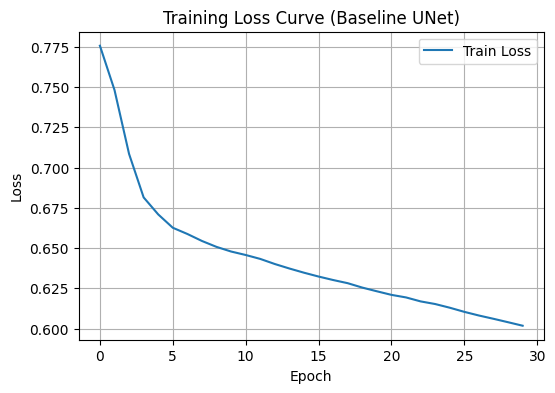

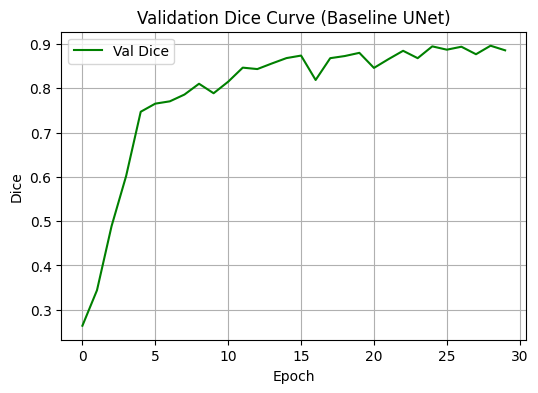

In [15]:
import matplotlib.pyplot as plt

# --- Loss Curve ---
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve (Baseline UNet)")
plt.legend()
plt.grid(True)
plt.show()

# --- Dice Curve ---
plt.figure(figsize=(6,4))
plt.plot(history["val_dice"], label="Val Dice", color="green")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title("Validation Dice Curve (Baseline UNet)")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
model.load_state_dict(torch.load("/content/drive/MyDrive/la_net/baseline_unet_best.ckpt"))
model.to(device)
model.eval()

print("Loaded best baseline UNet checkpoint.")


Loaded best baseline UNet checkpoint.


In [17]:
# Get one batch from val_loader
batch = next(iter(val_loader))
img, msk = batch
img = img.to(device)
msk = msk.to(device)

with torch.no_grad():
    logits = model(img)
    pred = torch.sigmoid(logits)
    pred_bin = (pred > 0.5).float()

print("Image shape:", img.shape)
print("Pred shape:", pred_bin.shape)


Image shape: torch.Size([1, 1, 128, 128, 128])
Pred shape: torch.Size([1, 1, 128, 128, 128])


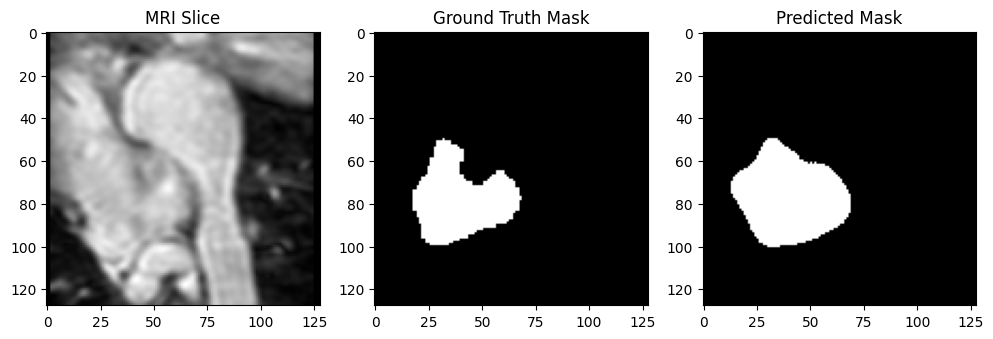

In [18]:
import matplotlib.pyplot as plt

# Move to CPU and remove batch/channel dims
img_np = img[0,0].detach().cpu().numpy()
msk_np = msk[0,0].detach().cpu().numpy()
pred_np = pred_bin[0,0].detach().cpu().numpy()

# Choose middle slice
z = img_np.shape[0] // 2

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_np[z], cmap="gray")
plt.title("MRI Slice")

plt.subplot(1,3,2)
plt.imshow(msk_np[z], cmap="gray")
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred_np[z], cmap="gray")
plt.title("Predicted Mask")

plt.show()


In [20]:
import numpy as np
import cv2

# Normalize MRI
img_slice = (img_np[z] / img_np[z].max() * 255).astype(np.uint8)
img_slice = cv2.cvtColor(img_slice, cv2.COLOR_GRAY2BGR)

# Color mask (red)
mask = (pred_np[z] * 255).astype(np.uint8)
mask_color = np.zeros_like(img_slice)
mask_color[:, :, 2] = mask

# Blend
overlay = cv2.addWeighted(img_slice, 0.7, mask_color, 0.3, 0)

save_path = "/content/drive/MyDrive/la_net/baseline_pred_overlay.png"
cv2.imwrite(save_path, overlay)
print("Saved overlay to:", save_path)


Saved overlay to: /content/drive/MyDrive/la_net/baseline_pred_overlay.png
